# Ensemble of models

Here I evaluate the hypotheses that an ensemble of models gives us a smaller rate of the False Positives hence better precision and, maybe, better F1.

I will combine 3 existing open-source baseline models.

The `conll2003_transformed` dataset is used for evaluation.

Predicted NE sis normalized since we want to follow the existing data preprocessing logic.

## Setting up

In [37]:
from pathlib import Path
import sys
import os
from collections import defaultdict
from collections import Counter

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score


In [38]:
# Add the parent directory to sys.path because we use code from the application
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    print(f"added {parent_dir}")
sys.path

['/home/leo/PycharmProjects/GLD/ner/experiments',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/leo/.local/lib/python3.10/site-packages',
 '/home/leo/PycharmProjects/opengpts/backend/packages/agent-executor',
 '/home/leo/PycharmProjects/opengpts/backend/packages/gizmo-agent',
 '/home/leo/PycharmProjects/GLD/test_rag_chroma/my-app/packages/rag-chroma',
 '/home/leo/PycharmProjects/unicli/uni_chat/packages/rag-chroma-private',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/leo/PycharmProjects/GLD/ner']

## Data loading

We are loading the datasets with NE predictions for 3 existing baseline models: `Hugging Face`, `NLTK`, and `spaCy`.

In [40]:
# Concatenate all df-s
def load_data(file_path, usecols=None, nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows)
    print(f"Loaded {df.shape} {file_path}, {list(df.columns) =}")
    return df
    
def load_all_data(data_path, used_columns, nrows=None):
    suffixes = "train test validation".split()
    
    all_df = pd.concat([load_data(
        data_path / f"conll2003_transformed.{suffix}.csv",
        usecols=used_columns, 
        nrows=nrows
    ) for suffix in suffixes])
    print(f"Summary df: {all_df.shape}, {list(all_df.columns) =}")
    return all_df


DATA_PATH = Path('../data/external/hf')
used_columns = "text persons organizations locations".split()
nrows = None
df = load_all_data(DATA_PATH, used_columns=used_columns, nrows=nrows)

Loaded (14041, 4) ../data/external/hf/conll2003_transformed.train.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Loaded (3453, 4) ../data/external/hf/conll2003_transformed.test.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Loaded (3250, 4) ../data/external/hf/conll2003_transformed.validation.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations']
Summary df: (20744, 4), list(all_df.columns) =['text', 'persons', 'locations', 'organizations']


## Data normalization

We use the existing normalizing code. Apply normalization only on `organizations`.

In [41]:
from ne_extractor_app.app.name_normalizer import Normalizer

In [42]:
tests = {
    'persons': 'Jon Doe;Jack;Osama bin Laden;Bin Laden;Jack Reach;Doe Jon',
    'organizations': 'Paris;Canada;Azhar University;Texas Department Of Public Safety;Paris;Detroit’s 12th Street;Public Safety Department',
    'locations': 'US Centers for Disease Control and Prevention;CNN;Tesla;MIT;Conviction Review Unit;the Seekers;Seekers'
}
normalizer = Normalizer()
normalizer.normalize_names(tests['organizations']), normalizer.normalize_names(tests['persons']), normalizer.normalize_names(tests['locations'])

('Paris;Canada;Azhar University;Texas Department Of Public Safety;Detroit’s 12th Street',
 'Jon Doe;Jack;Osama bin Laden;Jack Reach',
 'US Centers for Disease Control and Prevention;CNN;Tesla;MIT;Conviction Review Unit;the Seekers')

## All data combine and normalize

In [44]:
def get_predictor_files(data_dir, predictors):
    return {predictor: f"{data_dir}/{predictor}/with_scores.csv" for predictor in predictors}   

def load_data(file_path, usecols=['text', 'persons', 'organizations', 'locations', 'persons_pred', 'organizations_pred', 'locations_pred'], nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows, index_col=None)
    df.fillna('', inplace=True)
    return df

def filter_results(combined_result_row, threshold=0.6):
    return sorted(k for k, v in combined_result_row.items() if v > threshold)

def load_and_normalize(nrows=None):
    predictors = ['hf', 'nltk', 'spacy']
    data_dir = '../data/external/hf'
    normalizer = Normalizer()
    
    predictor2df = {
        predictor: load_data(file_path, nrows=nrows) 
        for predictor, file_path in get_predictor_files(data_dir, predictors).items()
    }

    for predictor, df in predictor2df.items():
        df.fillna('', inplace=True)
        df['organizations_pred'] = df['organizations_pred'].apply(normalizer.normalize_names)
        
    return predictor2df
    
def split_and_clean(val):
    if isinstance(val, str):
        return [item.strip() for item in val.split(';') if item.strip()]
    return []
    
def combine_column(column_name, predictor2df, weights, threshold):
    combined_results = []
    
    for idx in range(len(next(iter(predictor2df.values())))):  # Iterate over all rows
        substring_scores = defaultdict(float)
        
        # Accumulate scores from each dataframe based on weights
        for key, df in predictor2df.items():
            substrings = split_and_clean(df[column_name].iloc[idx])
            weight = weights[key]
            for substr in substrings:
                substring_scores[substr] += weight
        
        # Filter substrings based on threshold and combine them back into a single string
        filtered_substrings = [substr for substr, score in substring_scores.items() if score > threshold]
        combined_results.append(';'.join(filtered_substrings))
    
    return combined_results    

def combine_all(nrows=None, threshold=0.6):
    weights = {"nltk": 0.45, "spacy": 0.5, "hf": 0.55}   
    predictor2df = load_and_normalize(nrows=nrows)
    
    combined_df = pd.DataFrame({
        'persons_pred': combine_column('persons_pred', predictor2df, weights, threshold=threshold),
        'organizations_pred': combine_column('organizations_pred', predictor2df, weights, threshold=threshold),
        'locations_pred': combine_column('locations_pred', predictor2df, weights, threshold=threshold)
    })
    combined_df[['text', 'persons', 'organizations', 'locations']] = predictor2df['hf'][['text', 'persons', 'organizations', 'locations']]
    return combined_df.copy()


In [45]:

combined_df = combine_all(nrows=1)

/tmp/ipykernel_464906/1674918263.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)
/tmp/ipykernel_464906/1674918263.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)
/tmp/ipykernel_464906/1674918263.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


## Evaluations

In [46]:
import json
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score


def load_data(file_path, usecols=None, nrows=None):
    df = pd.read_csv(file_path, usecols=usecols, nrows=nrows)
    print(f"Loaded {df.shape} {file_path}, {list(df.columns) =}")
    return df

def save_results(output_file_path, metrics_file_path, df, metrics):
    df.to_csv(output_file_path, index=False)
    print(f"Results saved into {output_file_path}, rows: {df.shape[0]}")

    print(metrics)
    with open(metrics_file_path, "w", encoding='utf-8') as fp:
        json.dump(metrics, fp, check_circular=True)
    print(f"Metrics saved into {metrics_file_path}")
    
def evaluate_binary(df):
    def calculate_metrics(row):
        true_set = set(row[column].split(';'))
        pred_set = set(row[column+'_pred'].split(';'))
        
        tp = len(true_set & pred_set)  # True Positives
        fp = len(pred_set - true_set)  # False Positives
        fn = len(true_set - pred_set)  # False Negatives
        support = len(true_set)        # Support: the number of true values        
        return pd.Series([tp, fp, fn, support])
    
    overall_metrics = {}    
    for column in 'persons organizations locations'.split():
        # Apply the function to each row
        df[['TP_'+column, 'FP_'+column, 'FN_'+column, 'support_'+column]] = df.apply(calculate_metrics, axis=1)
        
        # Calculate precision, recall, F1 for each row
        df['precision_'+column] = df['TP_'+column] / (df['TP_'+column] + df['FP_'+column])
        df['recall_'+column] = df['TP_'+column] / (df['TP_'+column] + df['FN_'+column])
        df['F1_'+column] = 2 * (df['precision_'+column] * df['recall_'+column]) / (df['precision_'+column] + df['recall_'+column])
        
        # Fill NaN values (where precision/recall is undefined) with 0
        df.fillna(0, inplace=True)
        
        # Calculate overall precision, recall, F1-score, and support
        overall_metrics[column] ={
            "precision": round(sum(df['precision_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "recall": round(sum(df['recall_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "F1": round(sum(df['F1_'+column] * df['support_'+column]) /sum(df['support_'+column]), 3),
            "support": int(df['support_'+column].sum())
        }
    return df, overall_metrics   

    
def evaluate_baseline(df, output_file_path, metrics_file_path, do_cleanup=True, nrows=None):
    # Evaluate predictions against true labels
    out_df, overall_metrics = evaluate_binary(df)

    # Save the predictions to a CSV file (required format for submission)
    save_results(output_file_path, metrics_file_path, df=out_df, metrics=overall_metrics)
    print("Finish")
    return out_df, overall_metrics

In [50]:
from_source = 'external/hf'
dataset_name = "conll2003_transformed.all"
extractor_type = 'ensemble'

data_file_path = f"../data/{from_source}/{dataset_name}.csv"
output_file_path = f"../data/{from_source}/{extractor_type}/with_scores.csv"
metrics_file_path = f"../data/{from_source}/{extractor_type}/scores.json"
nrows = None
threshold = 0.5

combined_df = combine_all(nrows=nrows, threshold=threshold)

out_df, overall_metrics = evaluate_baseline(combined_df, output_file_path, metrics_file_path, do_cleanup=False, nrows=nrows)

## threshold = 0.45
# {'persons': {'precision': 0.769, 'recall': 0.873, 'F1': 0.799, 'support': 24248}, 'organizations': {'precision': 0.817, 'recall': 0.866, 'F1': 0.833, 'support': 23191}, 'locations': {'precision': 0.876, 'recall': 0.915, 'F1': 0.889, 'support': 23498}}

## threshold = 0.5
# {'persons': {'precision': 0.805, 'recall': 0.882, 'F1': 0.828, 'support': 24248}, 'organizations': {'precision': 0.915, 'recall': 0.928, 'F1': 0.919, 'support': 23191}, 'locations': {'precision': 0.915, 'recall': 0.938, 'F1': 0.922, 'support': 23498}}

## threshold = 0.55
# {'persons': {'precision': 0.896, 'recall': 0.854, 'F1': 0.867, 'support': 24248}, 'organizations': {'precision': 0.769, 'recall': 0.737, 'F1': 0.746, 'support': 23191}, 'locations': {'precision': 0.912, 'recall': 0.888, 'F1': 0.896, 'support': 23498}}

## threshold = 0.6
# {'persons': {'precision': 0.896, 'recall': 0.854, 'F1': 0.867, 'support': 24248}, 'organizations': {'precision': 0.769, 'recall': 0.737, 'F1': 0.746, 'support': 23191}, 'locations': {'precision': 0.912, 'recall': 0.888, 'F1': 0.896, 'support': 23498}}

Loaded (20744, 28) ../data/external/hf/hf/with_scores.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations', 'persons_pred', 'organizations_pred', 'locations_pred', 'TP_persons', 'FP_persons', 'FN_persons', 'support_persons', 'precision_persons', 'recall_persons', 'F1_persons', 'TP_organizations', 'FP_organizations', 'FN_organizations', 'support_organizations', 'precision_organizations', 'recall_organizations', 'F1_organizations', 'TP_locations', 'FP_locations', 'FN_locations', 'support_locations', 'precision_locations', 'recall_locations', 'F1_locations']
Loaded (20744, 28) ../data/external/hf/nltk/with_scores.csv, list(df.columns) =['text', 'persons', 'locations', 'organizations', 'persons_pred', 'organizations_pred', 'locations_pred', 'TP_persons', 'FP_persons', 'FN_persons', 'support_persons', 'precision_persons', 'recall_persons', 'F1_persons', 'TP_organizations', 'FP_organizations', 'FN_organizations', 'support_organizations', 'precision_organizations', 'recall_

In [14]:
overall_metrics

{'persons': {'precision': 0.896,
  'recall': 0.854,
  'F1': 0.867,
  'support': 24248},
 'organizations': {'precision': 0.769,
  'recall': 0.737,
  'F1': 0.746,
  'support': 23191},
 'locations': {'precision': 0.912,
  'recall': 0.888,
  'F1': 0.896,
  'support': 23498}}

# Results

I'm going to consolidate results of all models and analyze it.

In [51]:
results = {
    "NLTK": {'persons': {'precision': 0.791, 'recall': 0.779, 'F1': 0.778, 'support': 24248}, 'organizations': {'precision': 0.606, 'recall': 0.597, 'F1': 0.597, 'support': 23191}, 'locations': {'precision': 0.703, 'recall': 0.703, 'F1': 0.694, 'support': 23498}},
    "Hugging Face": {'persons': {'precision': 0.796, 'recall': 0.827, 'F1': 0.807, 'support': 24248}, 'organizations': {'precision': 0.93, 'recall': 0.935, 'F1': 0.932, 'support': 23191}, 'locations': {'precision': 0.921, 'recall': 0.925, 'F1': 0.922, 'support': 23498}},
    "spaCy": {'persons': {'precision': 0.843, 'recall': 0.803, 'F1': 0.814, 'support': 24248}, 'organizations': {'precision': 0.651, 'recall': 0.635, 'F1': 0.638, 'support': 23191}, 'locations': {'precision': 0.848, 'recall': 0.825, 'F1': 0.83, 'support': 23498}},
    "Ensemble": {'persons': {'precision': 0.805, 'recall': 0.882, 'F1': 0.828, 'support': 24248}, 'organizations': {'precision': 0.915, 'recall': 0.928, 'F1': 0.919, 'support': 23191}, 'locations': {'precision': 0.915, 'recall': 0.938, 'F1': 0.922, 'support': 23498}},
}

In [52]:
df_data = []
for model, v in results.items():
    for ne_type, metrics in v.items():
        for metric_type, metric_val in metrics.items():
            if metric_type != 'support':
                df_data.append({"model": model, "ne_type": ne_type, "metric_type": metric_type, "value": metric_val})
        
res_df = pd.DataFrame(df_data)
res_df.to_excel(Path(DATA_PATH / "compound_scores.xlsx"))
           

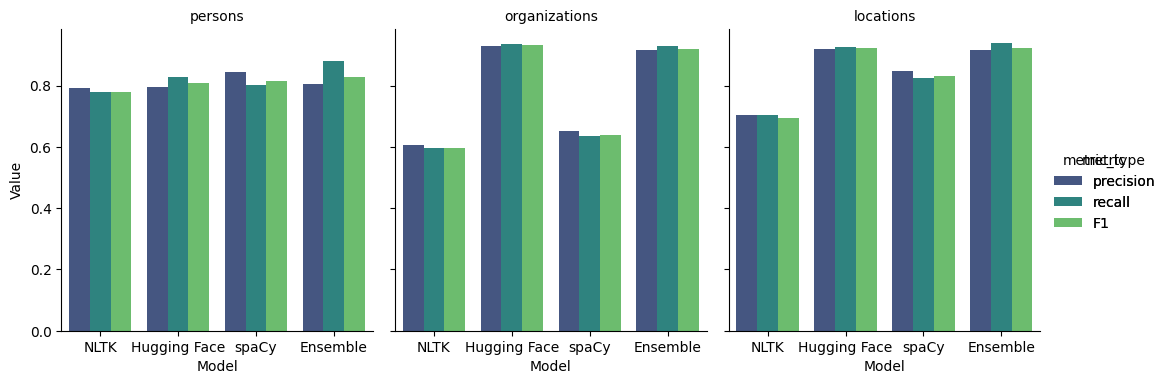

In [53]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = res_df

# Create a FacetGrid with seaborn to simulate a 3D effect by creating multiple plots
g = sns.catplot(
    data=df,
    x='model',
    y='value',
    hue='metric_type',
    col='ne_type',
    kind='bar',
    height=4,
    aspect=0.8,
    palette="viridis"
)

# Customize the layout
g.set_axis_labels("Model", "Value")
g.set_titles("{col_name}")
g.add_legend(title="metric")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('')
plt.show()


## Results and conclusion

The `Ensemble` model works better for the `person` NE. It is on par with the `Hugging Face` model for the `organizations` and `locations`.
